# Task 5 – Feature Engineering



## Setup

In [11]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from IPython.display import display

plt.ioff()

ROOT = Path('..')
DATA_PATH = ROOT / 'data' / 'raw' / 'train_252145.csv'
FIGURES_DIR = ROOT / 'reports' / 'figures'
TABLES_DIR = ROOT / 'reports' / 'tables'
PROCESSED_PATH = ROOT / 'data' / 'processed'

for path in [FIGURES_DIR, TABLES_DIR, PROCESSED_PATH]:
    path.mkdir(parents=True, exist_ok=True)

COLORS = {
    'demand': '#2ca02c',
    'temperature': '#F45B69',
    'irradiance': '#FFA500',
    'engineered': '#7f7f7f',
}

mpl.rcParams.update({
    'figure.dpi': 120,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'axes.titleweight': 'semibold',
    'axes.titlelocation': 'left',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'grid.color': '#d9d9d9',
    'grid.linestyle': '--',
    'grid.linewidth': 0.6,
    'axes.grid': True,
    'font.family': 'DejaVu Sans',
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.edgecolor': '#dddddd',
})

sns.set_theme(style='whitegrid')


def save_figure(fig, basename, dpi=300):
    """Save figure as PNG only."""
    png_path = FIGURES_DIR / f'{basename}.png'
    fig.savefig(png_path, dpi=dpi, bbox_inches='tight')
    print(f"Figure saved: {png_path}")
    return png_path

## Load dataset

In [12]:
# Load dataset
df = pd.read_csv(DATA_PATH, parse_dates=['timestamp']).sort_values('timestamp').set_index('timestamp')
weather_cols = [
    'Temperature', 'Pressure (hPa)', 'Cloud_cover (%)', 'Wind_speed_10m (km/h)',
    'Shortwave_radiation (W/m²)', 'direct_radiation (W/m²)',
    'diffuse_radiation (W/m²)', 'direct_normal_irradiance (W/m²)', 'Price'
]
subset = df[['Demand'] + weather_cols].copy()

print("Dataset Subset Head:")
display(subset.head())

Dataset Subset Head:


,Demand,Temperature,Pressure (hPa),Cloud_cover (%),Wind_speed_10m (km/h),Shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),Price
timestamp,,,,,,,,,,
2013-07-01 00:00:00+00:00,0.27,13.5,1011.3,4,10.5,NaN,0,0,0.0,0.01605
2013-07-01 01:00:00+00:00,0.23,13.2,1010.8,27,11.9,NaN,0,0,0.0,0.00095
2013-07-01 02:00:00+00:00,0.26,13.1,1010.3,33,11.6,NaN,0,0,0.0,0.00060
2013-07-01 03:00:00+00:00,0.28,13.0,1010.3,28,11.2,NaN,2,7,30.1,0.00046
2013-07-01 04:00:00+00:00,0.29,13.8,1010.2,16,11.7,NaN,30,31,252.0,0.00046


## Descriptive statistics

In [13]:
# Calculate descriptive statistics
stats_functions = ['mean', 'std', 'min', 'max']
summary = subset.agg(stats_functions).T
extra = subset.agg(['skew', 'kurtosis']).T
summary['skewness'] = extra['skew']
summary['kurtosis'] = extra['kurtosis']
summary = summary.round(3)
summary_path = TABLES_DIR / 'task5_descriptive_stats.csv'
summary.to_csv(summary_path)

print("Descriptive Statistics:")
display(summary)

Descriptive Statistics:


,mean,std,min,max,skewness,kurtosis
Demand,0.531,0.375,0.0,4.240,2.484,8.801
Temperature,7.515,8.312,-18.3,28.900,-0.209,-0.023
Pressure (hPa),1012.776,10.199,971.7,1041.000,-0.375,0.795
Cloud_cover (%),68.705,36.274,0.0,100.000,-0.778,-0.955
Wind_speed_10m (km/h),15.991,7.451,0.4,51.100,0.505,-0.044
Shortwave_radiation (W/m²),114.955,181.902,0.0,756.000,1.661,1.751
direct_radiation (W/m²),67.146,133.208,0.0,702.000,2.299,4.642
diffuse_radiation (W/m²),45.229,63.792,0.0,343.000,1.479,1.587
direct_normal_irradiance (W/m²),143.466,232.824,0.0,896.700,1.563,1.210
Price,0.046,0.025,0.0,0.255,1.200,5.481


### Figure 1 – Demand vs temperature

Figure saved: ../reports/figures/05_demand_vs_temperature.png


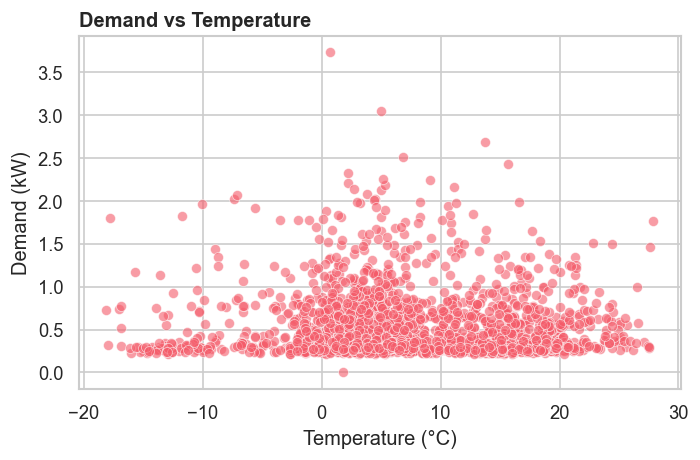

In [14]:
# Figure 1: Demand vs Temperature scatter plot
# This visualization explores the relationship between ambient temperature and electricity demand
sample_temp = subset.sample(2000, random_state=42)

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=sample_temp, x='Temperature', y='Demand', color=COLORS['temperature'], alpha=0.6, ax=ax)
ax.set_title('Demand vs Temperature')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Demand (kW)')
fig.tight_layout()

save_figure(fig, '05_demand_vs_temperature')
plt.show()

### Figure 2 – Hourly demand profile

Figure saved: ../reports/figures/05_demand_hourly_profile.png


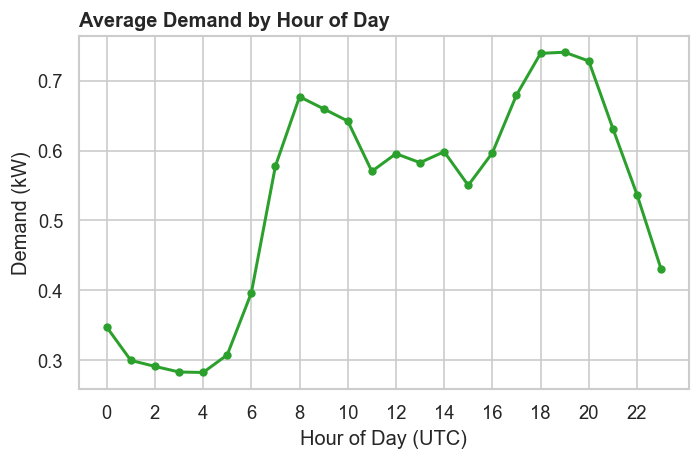

In [15]:
# Figure 2: Average Hourly Demand Profile
# Shows the typical diurnal pattern of electricity consumption
hour_profile = df['Demand'].groupby(df.index.hour).mean()
hour_profile.index.name = 'hour'
hour_profile = hour_profile.reset_index()

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(hour_profile['hour'], hour_profile['Demand'], color=COLORS['demand'], linewidth=1.8, marker='o', markersize=4)
ax.set_title('Average Demand by Hour of Day')
ax.set_xlabel('Hour of Day (UTC)')
ax.set_ylabel('Demand (kW)')
ax.set_xticks(range(0, 24, 2))
fig.tight_layout()

save_figure(fig, '05_demand_hourly_profile')
plt.show()

### Figure 3 – Demand vs shortwave radiation

Figure saved: ../reports/figures/05_demand_vs_radiation.png


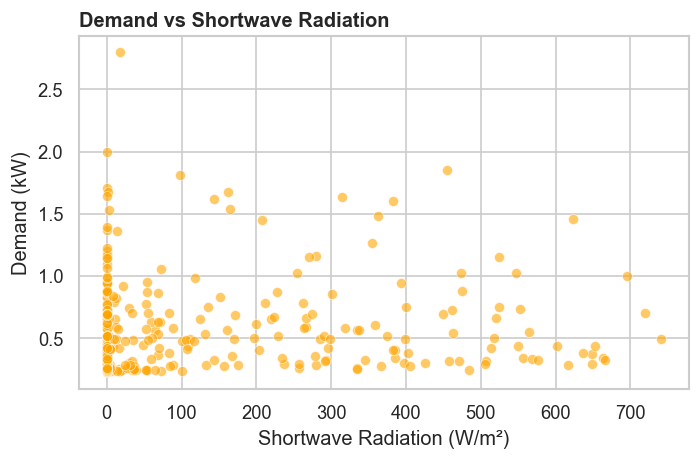

In [16]:
# Figure 3: Demand vs Shortwave Radiation
# Explores the relationship between solar irradiance and demand
irr_sample = subset.sample(2000, random_state=21)

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=irr_sample, x='Shortwave_radiation (W/m²)', y='Demand', color=COLORS['irradiance'], alpha=0.6, ax=ax)
ax.set_title('Demand vs Shortwave Radiation')
ax.set_xlabel('Shortwave Radiation (W/m²)')
ax.set_ylabel('Demand (kW)')
fig.tight_layout()

save_figure(fig, '05_demand_vs_radiation')
plt.show()

## Distribution analysis and transformations

Figure saved: ../reports/figures/05_distribution_Demand.png


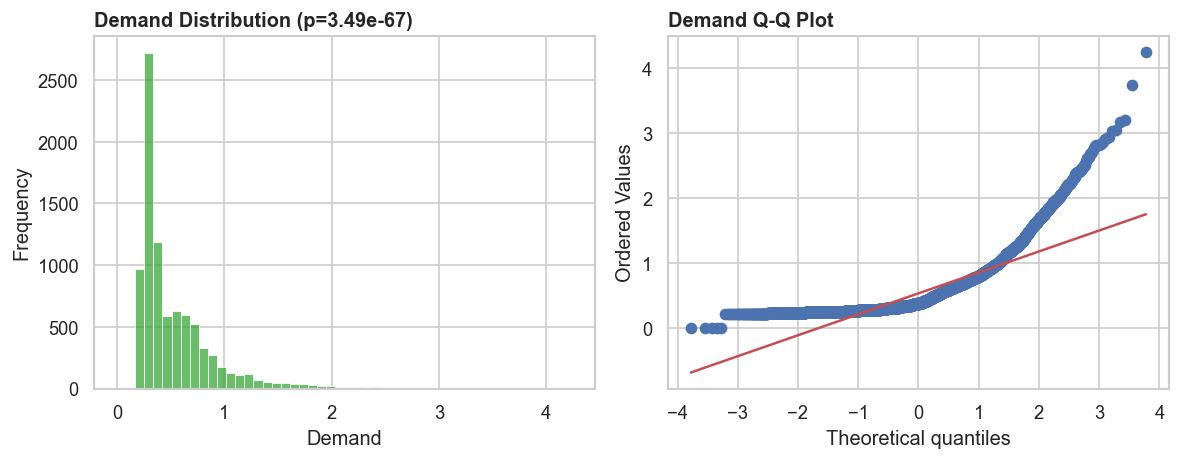


Demand is NOT normally distributed (p < 0.05). Applying Yeo-Johnson transformation...
Figure saved: ../reports/figures/05_distribution_Demand_transformed.png
Figure saved: ../reports/figures/05_distribution_Demand_transformed.png


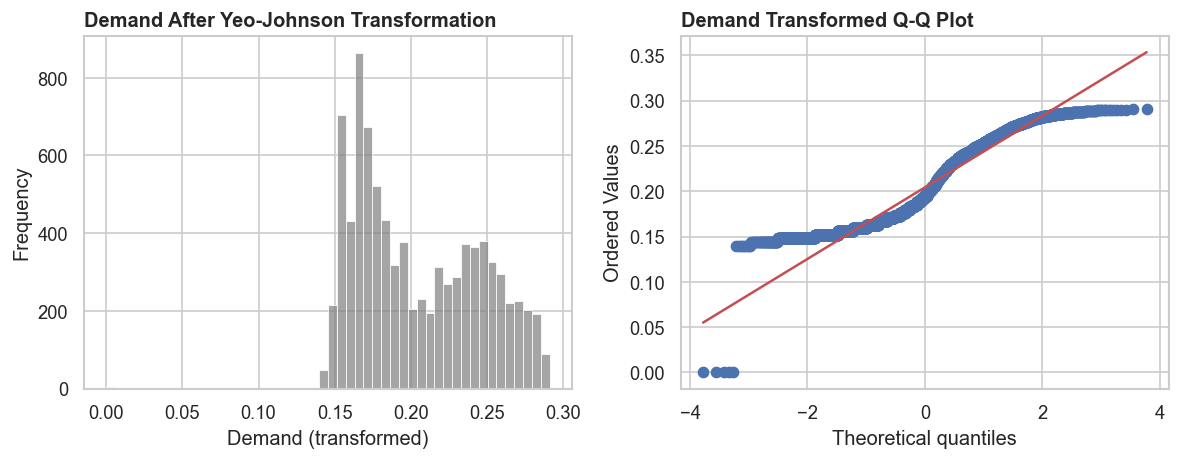

Figure saved: ../reports/figures/05_distribution_Temperature.png


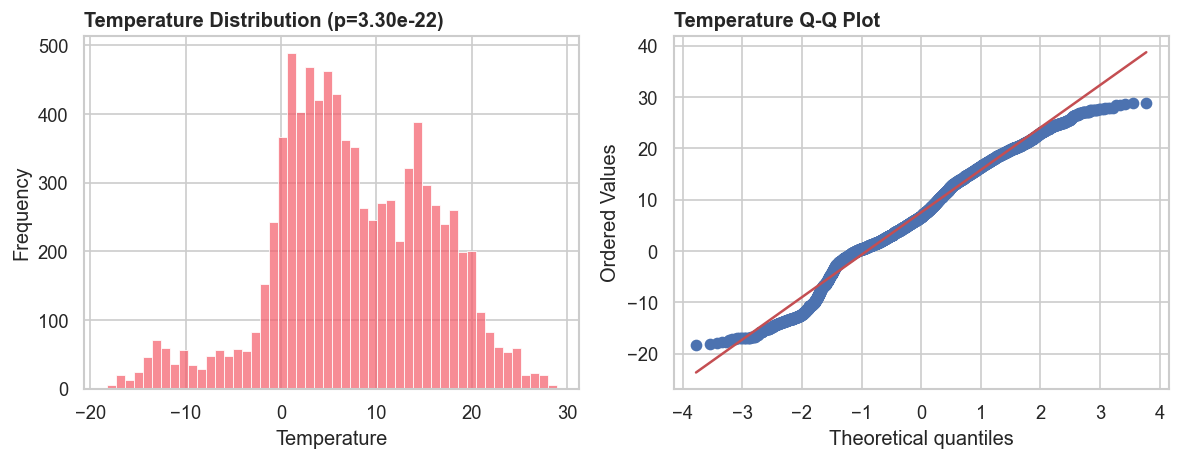


Temperature is NOT normally distributed (p < 0.05). Applying Yeo-Johnson transformation...
Figure saved: ../reports/figures/05_distribution_Temperature_transformed.png
Figure saved: ../reports/figures/05_distribution_Temperature_transformed.png


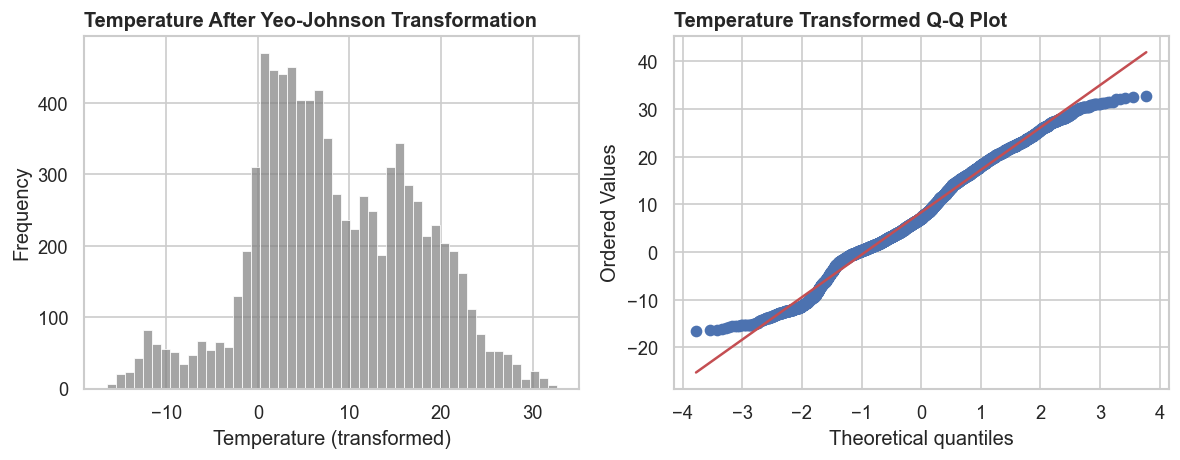

Figure saved: ../reports/figures/05_distribution_Shortwave_radiation_W_m2.png


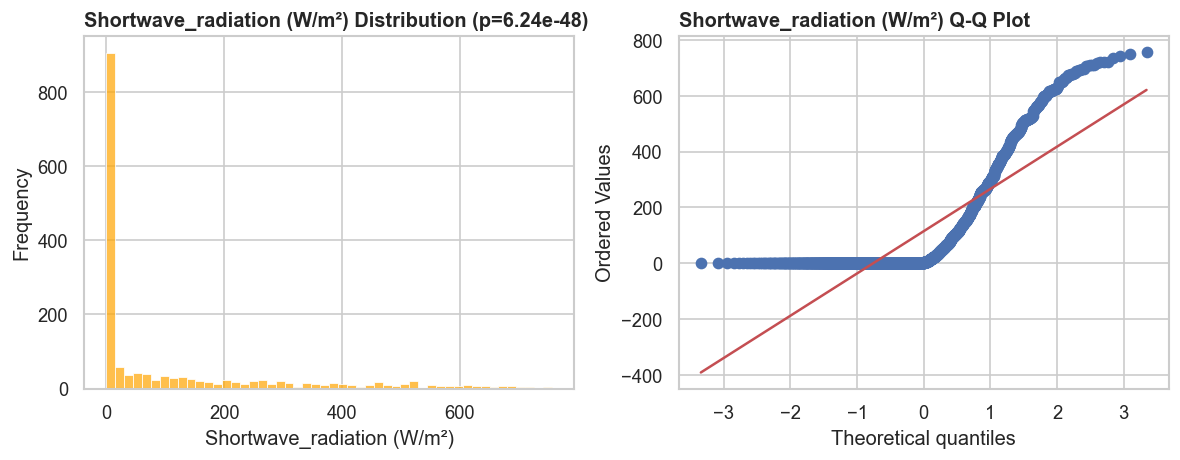


Shortwave_radiation (W/m²) is NOT normally distributed (p < 0.05). Applying Yeo-Johnson transformation...
Figure saved: ../reports/figures/05_distribution_Shortwave_radiation_W_m2_transformed.png
Figure saved: ../reports/figures/05_distribution_Shortwave_radiation_W_m2_transformed.png


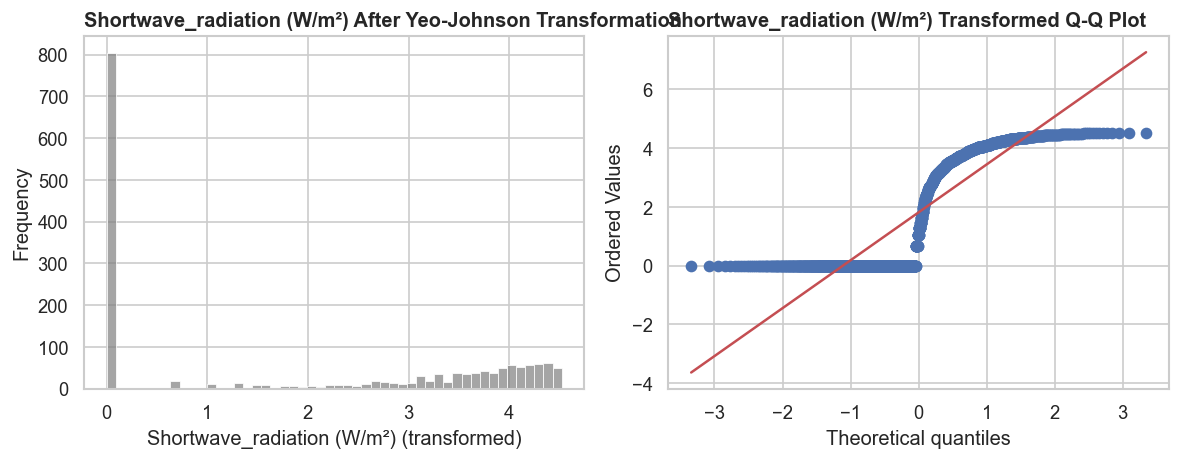


Normality Test Results:


,Variable,Shapiro-Wilk Stat,p-value,Normal
0,Demand,0.732834,3.491699e-67,False
1,Temperature,0.985567,3.298669e-22,False
2,Shortwave_radiation (W/m²),0.690381,6.240503e-48,False


In [17]:
# Distribution analysis and normality testing
# Use Shapiro-Wilk test to check for normal distribution
# Apply Yeo-Johnson transformation if data is not normally distributed

transformer = PowerTransformer(method='yeo-johnson', standardize=False)
analysis_vars = ['Demand', 'Temperature', 'Shortwave_radiation (W/m²)']

normality_results = []

for var in analysis_vars:
    series = subset[var].dropna()
    # Shapiro-Wilk test requires sample size < 5000
    sample = series.sample(min(5000, len(series)), random_state=42)
    stat, pvalue = stats.shapiro(sample)
    is_normal = pvalue > 0.05
    normality_results.append({'Variable': var, 'Shapiro-Wilk Stat': stat, 'p-value': pvalue, 'Normal': is_normal})
    
    # Create distribution plot with histogram and Q-Q plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    color = COLORS['demand'] if var == 'Demand' else (COLORS['temperature'] if 'Temp' in var else COLORS['irradiance'])
    sns.histplot(series, bins=50, color=color, alpha=0.7, ax=axes[0])
    axes[0].set_title(f'{var} Distribution (p={pvalue:.2e})')
    axes[0].set_xlabel(var)
    axes[0].set_ylabel('Frequency')
    
    stats.probplot(series, dist='norm', plot=axes[1])
    axes[1].set_title(f'{var} Q-Q Plot')
    fig.tight_layout()
    
    base_name = var.replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '').replace('²', '2')
    save_figure(fig, f'05_distribution_{base_name}')
    plt.show()
    
    # Apply transformation if not normally distributed
    if not is_normal:
        print(f"\n{var} is NOT normally distributed (p < 0.05). Applying Yeo-Johnson transformation...")
        transformed = transformer.fit_transform(series.values.reshape(-1, 1)).flatten()
        
        # Create transformed distribution plot
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        sns.histplot(transformed, bins=50, color=COLORS['engineered'], alpha=0.7, ax=axes[0])
        axes[0].set_title(f'{var} After Yeo-Johnson Transformation')
        axes[0].set_xlabel(f'{var} (transformed)')
        axes[0].set_ylabel('Frequency')
        
        stats.probplot(transformed, dist='norm', plot=axes[1])
        axes[1].set_title(f'{var} Transformed Q-Q Plot')
        fig.tight_layout()
        
        save_figure(fig, f'05_distribution_{base_name}_transformed')
        plt.show()
    else:
        print(f"\n{var} appears normally distributed (p >= 0.05).")

# Save normality test results
normality_df = pd.DataFrame(normality_results)
normality_df.to_csv(TABLES_DIR / 'task5_normality_tests.csv', index=False)
print("\nNormality Test Results:")
display(normality_df)

## Feature engineering

In [18]:
# Create engineered features
features = df.copy()
features['hour'] = features.index.hour
features['dayofweek'] = features.index.dayofweek
features['is_weekend'] = (features['dayofweek'] >= 5).astype(int)
features['hour_sin'] = np.sin(2 * np.pi * features['hour'] / 24)
features['hour_cos'] = np.cos(2 * np.pi * features['hour'] / 24)
features['cooling_degree'] = np.clip(features['Temperature'] - 18, 0, None)
features['heating_degree'] = np.clip(18 - features['Temperature'], 0, None)
features['temp_irradiance_interaction'] = features['Temperature'] * features['Shortwave_radiation (W/m²)']
selected_cols = ['Demand', 'hour_sin', 'hour_cos', 'is_weekend', 'cooling_degree', 'heating_degree',
                 'temp_irradiance_interaction'] + weather_cols
processed_path = PROCESSED_PATH / 'task5_features.parquet'
features[selected_cols].to_parquet(processed_path)

print("Engineered Features (Head):")
display(features[selected_cols].head())

Engineered Features (Head):


,Demand,hour_sin,hour_cos,is_weekend,cooling_degree,heating_degree,temp_irradiance_interaction,Temperature,Pressure (hPa),Cloud_cover (%),Wind_speed_10m (km/h),Shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),Price
timestamp,,,,,,,,,,,,,,,,
2013-07-01 00:00:00+00:00,0.27,0.000000,1.000000,0,0.0,4.5,NaN,13.5,1011.3,4,10.5,NaN,0,0,0.0,0.01605
2013-07-01 01:00:00+00:00,0.23,0.258819,0.965926,0,0.0,4.8,NaN,13.2,1010.8,27,11.9,NaN,0,0,0.0,0.00095
2013-07-01 02:00:00+00:00,0.26,0.500000,0.866025,0,0.0,4.9,NaN,13.1,1010.3,33,11.6,NaN,0,0,0.0,0.00060
2013-07-01 03:00:00+00:00,0.28,0.707107,0.707107,0,0.0,5.0,NaN,13.0,1010.3,28,11.2,NaN,2,7,30.1,0.00046
2013-07-01 04:00:00+00:00,0.29,0.866025,0.500000,0,0.0,4.2,NaN,13.8,1010.2,16,11.7,NaN,30,31,252.0,0.00046


## Feature ranking

In [19]:
# Rank features using Mutual Information and Random Forest
clean = features[selected_cols].dropna()
sample = clean.sample(min(1000, len(clean)), random_state=42)
X = sample.drop(columns=['Demand'])
y = sample['Demand']

mi_scores = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns, name='mutual_information').sort_values(ascending=False)
mi_series.round(4).to_csv(TABLES_DIR / 'task5_feature_ranking_mi.csv')

rf = RandomForestRegressor(n_estimators=80, random_state=42, n_jobs=-1)
rf.fit(X, y)
perm_scores = permutation_importance(rf, X, y, n_repeats=3, random_state=42, n_jobs=-1)
perm_series = pd.Series(perm_scores.importances_mean, index=X.columns, name='permutation').sort_values(ascending=False)
perm_series.round(4).to_csv(TABLES_DIR / 'task5_feature_ranking_permutation.csv')
combined = pd.concat([mi_series, perm_series], axis=1)
combined.to_csv(TABLES_DIR / 'task5_feature_ranking_combined.csv')

print("Feature Ranking:")
display(combined.head())

Feature Ranking:


,mutual_information,permutation
hour_cos,0.133851,0.293501
hour_sin,0.109495,0.515502
heating_degree,0.089476,0.161763
Temperature,0.081546,0.132669
Cloud_cover (%),0.067358,0.097224


### Figure 4 – Top features (mutual information)

Figure saved: ../reports/figures/05_feature_ranking_mi.png


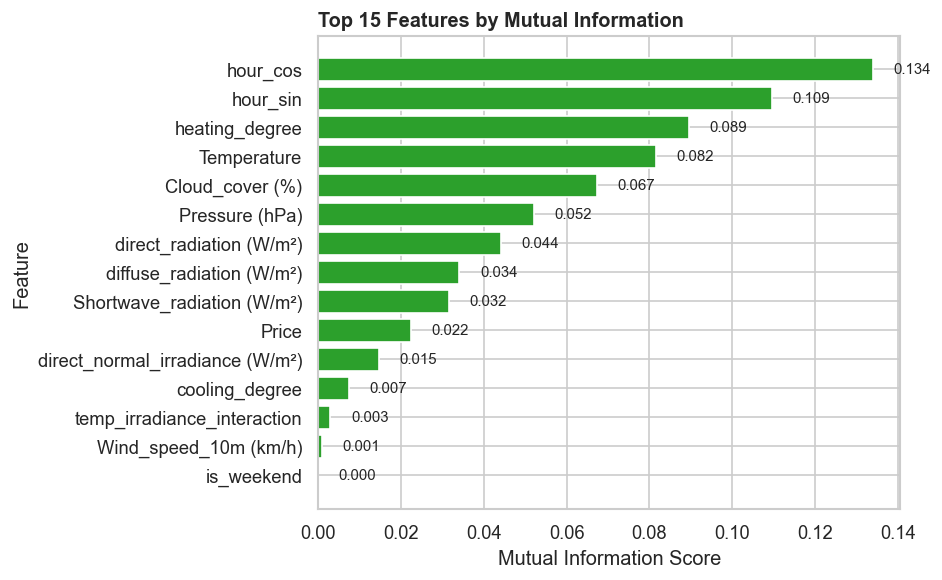

In [20]:
# Figure 4: Feature Ranking by Mutual Information
# Visualize the top 15 most informative features for demand prediction
top15 = mi_series.head(15)

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(top15.index[::-1], top15.values[::-1], color=COLORS['demand'])
ax.set_title('Top 15 Features by Mutual Information')
ax.set_xlabel('Mutual Information Score')
ax.set_ylabel('Feature')

# Add value labels on bars
for bar, val in zip(bars, top15.values[::-1]):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
            va='center', fontsize=9)

fig.tight_layout()
save_figure(fig, '05_feature_ranking_mi')
plt.show()